In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from plotters import _boxplot_one_variable

In [2]:
data = pd.read_csv('/home/pacorofe/Dropbox (CRG ADV)/ZFISH_MICs/_BSocial/2022_ANALYSIS_social/generated_figures/boxplot_line_replicate_mean_stat_tr_indivs_bl/data.csv')

In [11]:
def _boxplot_axes_one_variable(ax, data, variable):
    ax.axhline(data[variable].median(), c='k')
    ax.axhline(data[variable].mean(), ls='--', c='k')
    ax.axhline(data[variable].quantile(0.25), c='.25')
    ax.axhline(data[variable].quantile(0.75), c='.25')
    q1 = data[variable].quantile(0.25)
    q3 = data[variable].quantile(0.75)
    iqr = (q3-q1)
    whis_low = q1 - 1.5 * iqr
    whis_high = q3 + 1.5 * iqr
    ax.axhline(whis_low, c='.25')
    ax.axhline(whis_high, c='.25')

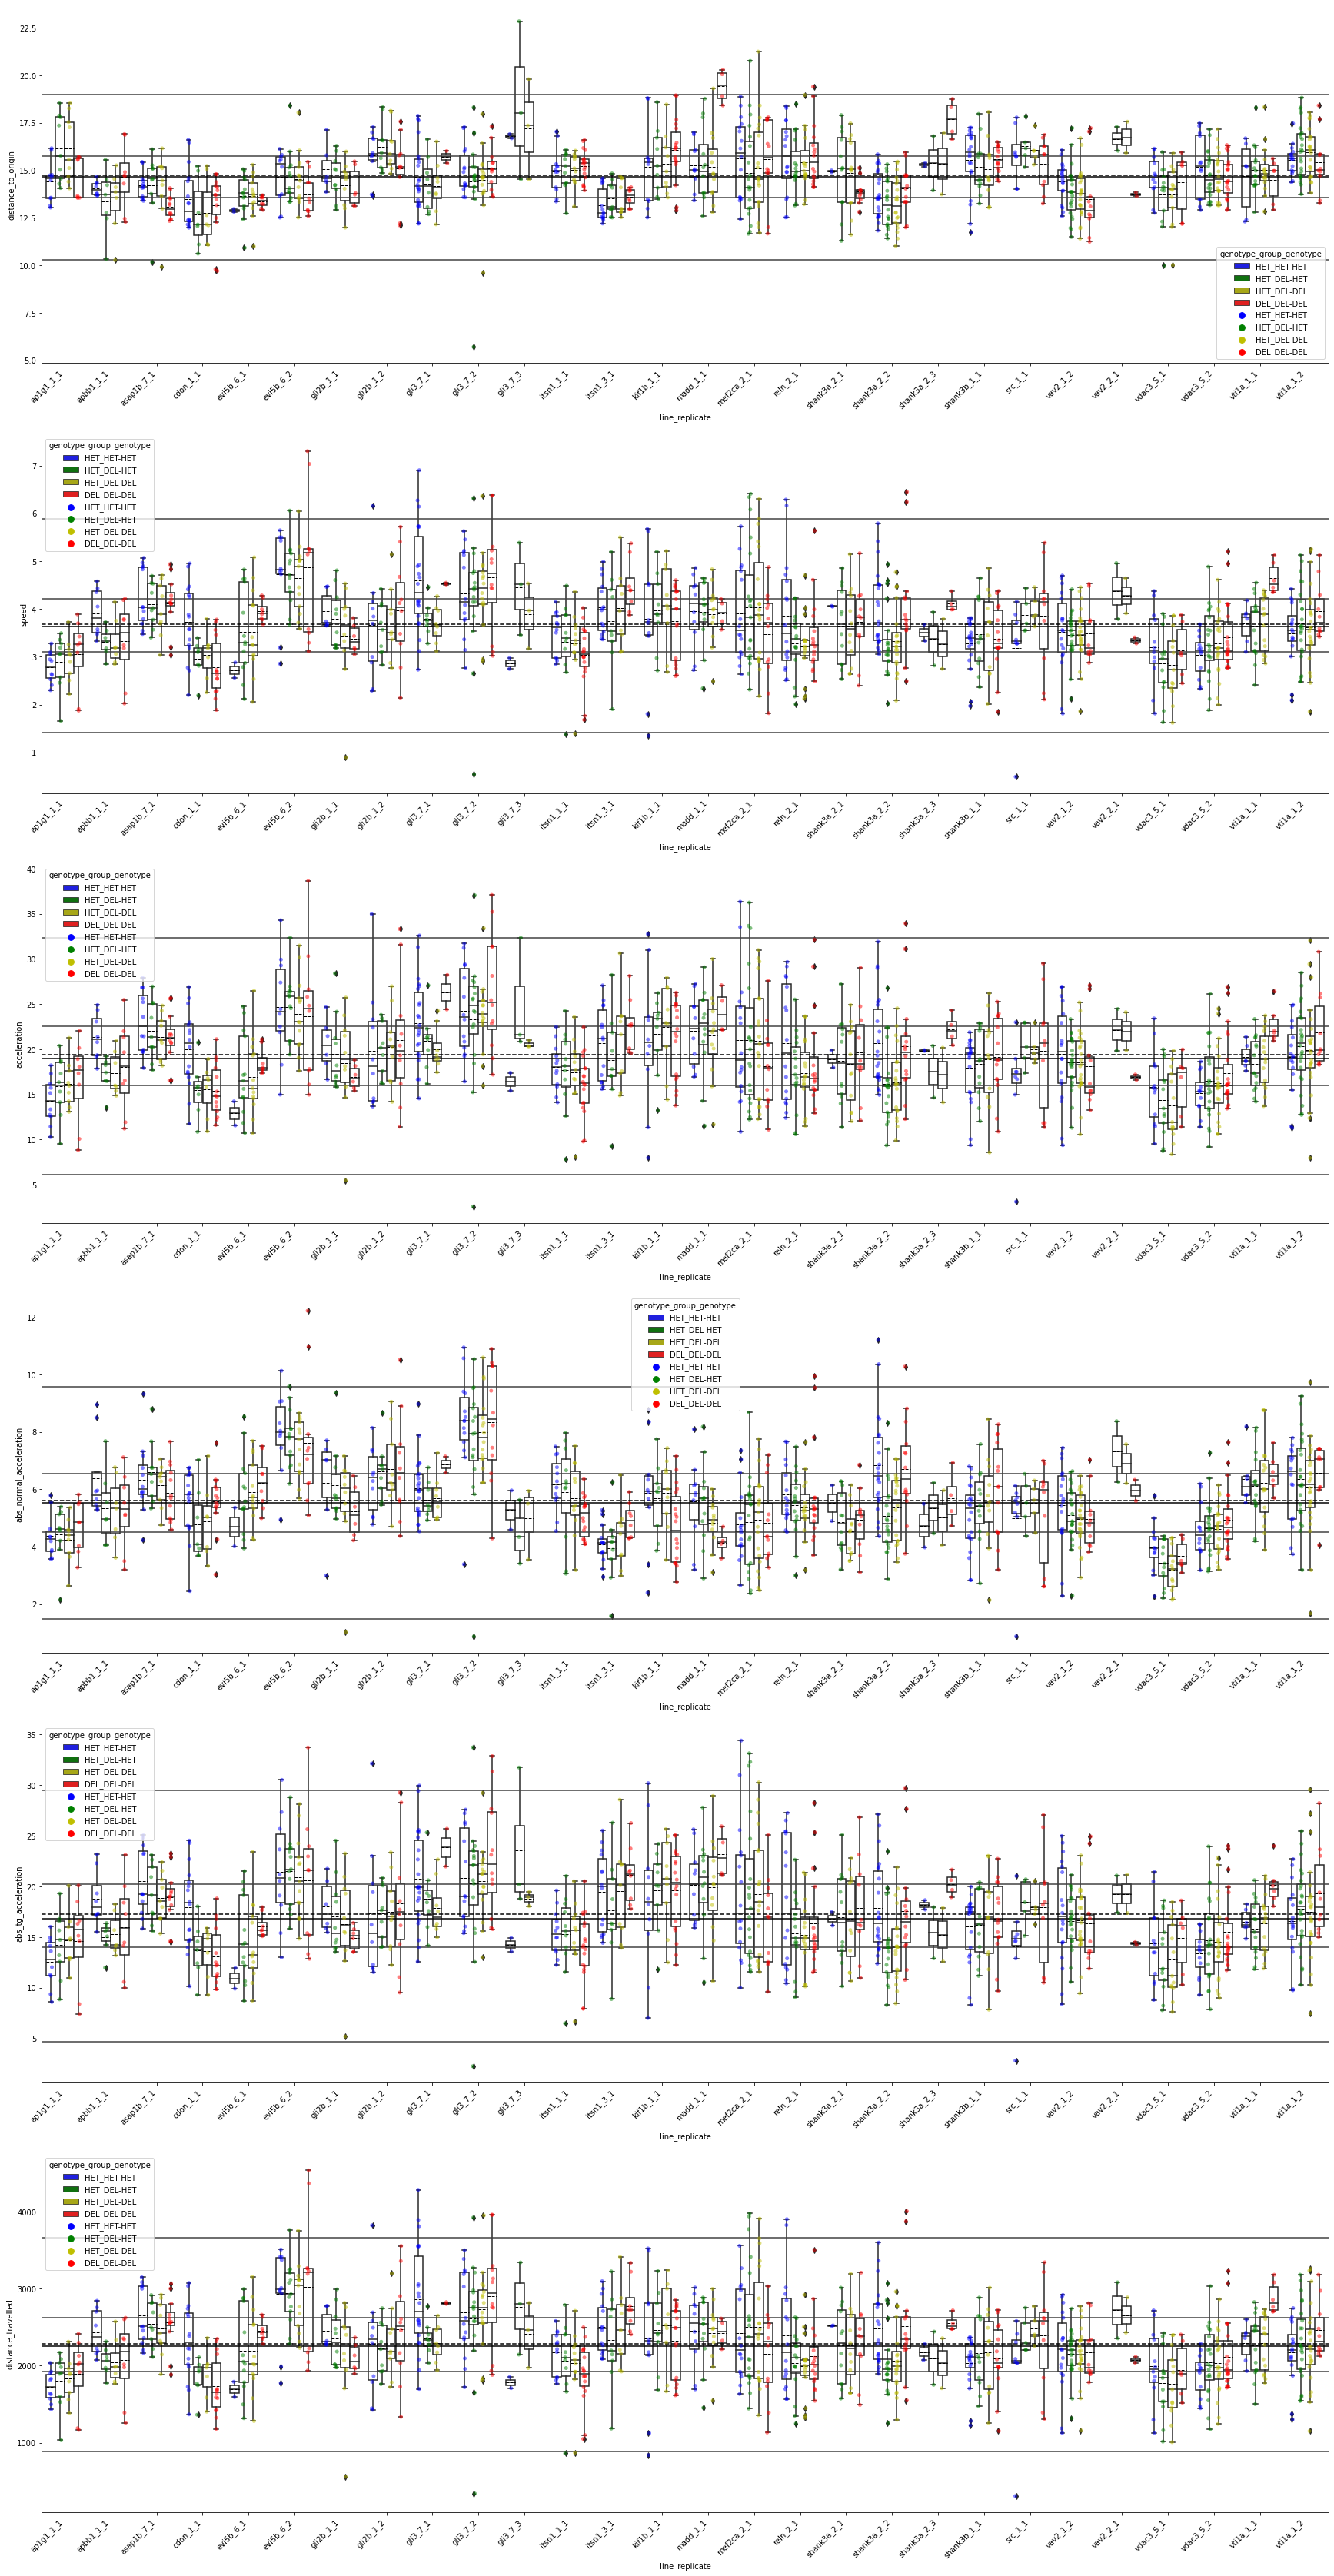

In [12]:
variables = [
    "distance_to_origin",
    "speed",
    "acceleration",
    "abs_normal_acceleration",
    "abs_tg_acceleration",
    "distance_travelled"
]
fig, axs = plt.subplots(len(variables),1,figsize=(30,10 * len(variables)))
data['genotype_group_genotype'] = data['genotype_group'] + '-' + data['genotype']
colors = {'HET_HET-HET': 'b', 'HET_DEL-HET': 'g', 'HET_DEL-DEL': 'y', 'DEL_DEL-DEL': 'r'}
for ax, variable in zip(axs, variables):
    _boxplot_one_variable(
        ax, 
        data, 
        {
            "x": 'line_replicate', 
            'y': variable, 
            'hue': "genotype_group_genotype", 
            "palette":colors, 
            "order":data.line_replicate.unique(), 
            "hue_order":colors.keys(), 
            "whis": 1.5
        }
    )
    _boxplot_axes_one_variable(ax, data, variable)
